# Početní odhady

* originál viz: [A.B.Downey: Think Bayes,5. Estimating Counts](http://allendowney.github.io/ThinkBayes2/chap05.html)


## Odhad počtu vlaků

### Zadání

* Železniční společnost čísluje vlaky 1..N. 
* Pozorujeme vlak č. 60.
* Jaký je náš nejlepší možný odhad cekového počtu vlaků N?

### Řešení

$$ posterior = prior \times likelihood $$

* prior: 
  $$X \sim Unif(1,1000)$$
* věrohodnost (likelihood): 
  
  $$ P(see ~ 60|exist ~ x) = \begin{cases} 0  ~~ \text{pro} ~~ x < 60 \\ 1 / x ~~ \text{pro} ~~ x \ge 60 \end{cases} $$

#### Prior 

* Zkonstruujeme neinformovaný prior v rozsahu 1 až 1000

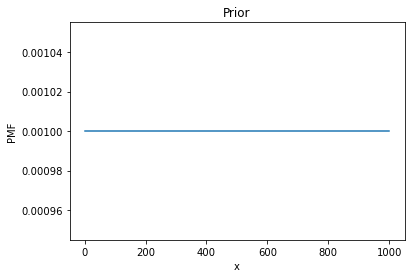

In [116]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from empiricaldist import Pmf

def decor(title):
    plt.xlabel('x')
    plt.ylabel('PMF')
    plt.title(title)

hypos = np.arange(1, 1001)     
prior = Pmf.from_seq(hypos)         # rovnoměrný prior 1..1000

prior.plot();
decor('Prior')

In [117]:
print(prior)
print(prior.qs[:10])
print(prior.ps[:10])

1       0.001
2       0.001
3       0.001
4       0.001
5       0.001
        ...  
996     0.001
997     0.001
998     0.001
999     0.001
1000    0.001
Name: , Length: 1000, dtype: float64
[ 1  2  3  4  5  6  7  8  9 10]
[0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001]


#### Věrohodnost (likelihood)

* Pravděpodobnost, že pozoruji data (vlak č. 60) , za předpokladu hypotézy (X = x).


1       0.000000
2       0.000000
3       0.000000
4       0.000000
5       0.000000
          ...   
996     0.001004
997     0.001003
998     0.001002
999     0.001001
1000    0.001000
Name: , Length: 1000, dtype: float64


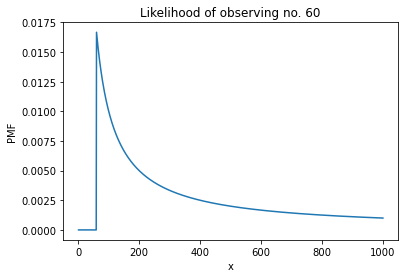

In [118]:
def likelihood(data, hypo):
    """ returns P(data|hypo)"""
    return 1 / hypo if hypo >= data else 0


lik_60 = Pmf([likelihood(60, x) for x in prior.qs], prior.qs)


print(lik_60)
lik_60.plot();
decor('Likelihood of observing no. 60')

#### Posterior

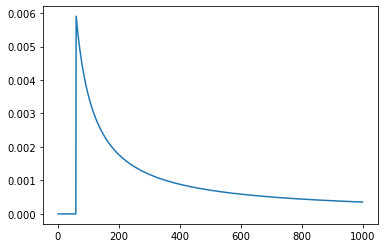

In [123]:
trains = prior.copy()
trains.update(likelihood, 60)
trains.plot();

In [129]:
trains.max_prob()

60

In [130]:
trains.mean()

333.4198932637079

In [166]:
trains.credible_interval(.9)     # (bayesovský) interval spolehlivosti

array([ 69., 869.])

#### Citlivost na prior

In [133]:
import pandas as pd

df = pd.DataFrame(columns=['Posterior mean'])
df.index.name = 'Upper bound'

for high in [500, 1000, 2000]:
    hypos = np.arange(1, high+1)
    pmf = Pmf(1, hypos)
    pmf.update(likelihood, data=60)
    df.loc[high] = pmf.mean()
    
df

,Posterior mean
Upper bound,
500,207.079228
1000,333.419893
2000,552.179017


#### Více dat

* Pozorujeme čísla 60, 30, 90.

In [134]:
df = pd.DataFrame(columns=['Posterior mean'])
df.index.name = 'Upper bound'

dataset = [30, 60, 90]

for high in [500, 1000, 2000]:
    hypos = np.arange(1, high+1)
    pmf = Pmf(1, hypos)
    for data in dataset:
        pmf.update(likelihood, data)
    df.loc[high] = pmf.mean()
    
df

,Posterior mean
Upper bound,
500,151.849588
1000,164.305586
2000,171.338181


#### Paretovský prior

* Mnoho věcí je rozděleno tzv. paretovsky (power law)
    * existuje málo obrovských exemplářů, ale velmi mnoho těch malých
    * zemětřesení, majetky, četnost příjmení, velikost firem
* Paretovské rozdělení odpovídá víceméně hyperbole
$$ f(x) \sim \dfrac{1}{x^{\alpha + 1}} $$

* Společnost s 100 lokomotivami je podobně častá jako 100 společností s jednou lokomotivou


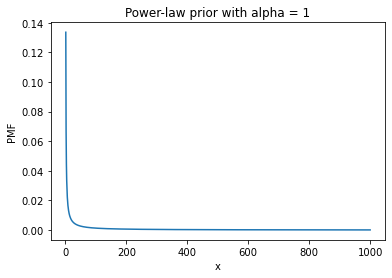

In [153]:
alpha = 1.0
hypos = np.arange(1,1001)
ps = hypos**(-alpha)
power = Pmf(ps, hypos, name='power law')
power.normalize()
power.plot();
decor('Power-law prior with alpha = 1')
#plt.xscale('log')
#plt.yscale('log')

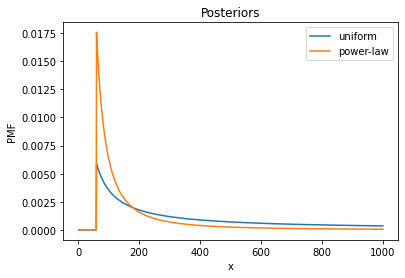

In [159]:
trains = prior.copy()
trains.update(likelihood, 60)
trains.plot();

trains_power = power.copy()
trains_power.update(likelihood, 60)
trains_power.plot();

decor('Posteriors')
plt.legend(['uniform', 'power-law']);



In [164]:
trains_power.credible_interval(.9)

array([ 62., 559.])

#### Citlivost na prior

In [163]:
df = pd.DataFrame(columns=['Posterior mean'])
df.index.name = 'Upper bound'

alpha = 1.0
dataset = [30, 60, 90]

for high in [500, 1000, 2000]:
    hypos = np.arange(1, high+1)
    ps = hypos**(-alpha)
    power = Pmf(ps, hypos)
    for data in dataset:
        power.update(likelihood, data)
    df.loc[high] = power.mean()
    
df

,Posterior mean
Upper bound,
500,130.708470
1000,133.275231
2000,133.997463


In [165]:
power.credible_interval(.9)

array([ 91., 243.])

## Odhad počtu lidí v sále

### Zadání

Jaká je pravděpodobnost, že v sále je víc než 1200 lidí?

* Kolik lidí má narozeniny 11. května?   
  * 2 lidé
* Kolik lidí má narozeniny 5. května?    
  * 1 člověk
* Kolik lidí má narozeniny 23. srpna?
  * nikdo
  
### Řešení  
  
#### Prior

$$ P(x) \sim Unif(800,1600) $$

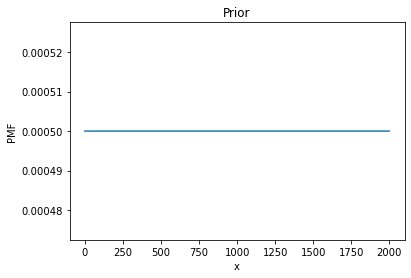

In [191]:
hypos = np.arange(0, 2000)     
prior = Pmf.from_seq(hypos)         # rovnoměrný prior 800..1600

prior.plot();
decor('Prior')

#### Věrohodnost

* Pravděpodobnost, že *k* osob z *x* má narozeniny konkrétní den.

$$ P(k|x) = {x\choose k} \cdot \left( \frac{1}{365} \right)^k \cdot \left(\frac{364}{365}\right)^{x-k}  $$

* viz [Binomické rozdělení](https://cs.wikipedia.org/wiki/Binomick%C3%A9_rozd%C4%9Blen%C3%AD)

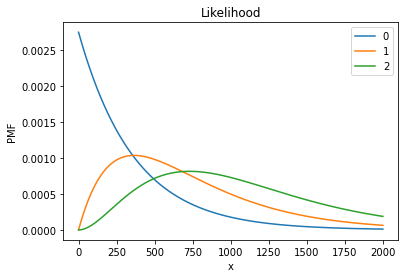

In [193]:
import math

def likelihood(data, hypo):
    """ returns P(data|hypo)"""
    return ((1/365)**data) * ((364/365)**(hypo-data)) * math.comb(hypo, data) if hypo >= data else 0

lik_0 = Pmf([likelihood(0, x) for x in prior.qs], prior.qs)
lik_1 = Pmf([likelihood(1, x) for x in prior.qs], prior.qs)
lik_2 = Pmf([likelihood(2, x) for x in prior.qs], prior.qs)

lik_0.normalize()
lik_1.normalize()
lik_2.normalize()

lik_0.plot();
lik_1.plot();
lik_2.plot();
decor('Likelihood');
plt.legend(['0','1','2']);

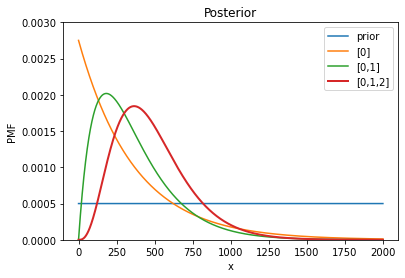

In [209]:
post = prior.copy()
post.plot();
post.update(likelihood, 0)
post.plot();
post.update(likelihood, 1)
post.plot();
post.update(likelihood, 2)
post.plot(lw=2);
decor('Posterior')
plt.ylim([0,0.003])
plt.legend(['prior','[0]','[0,1]','[0,1,2]']);

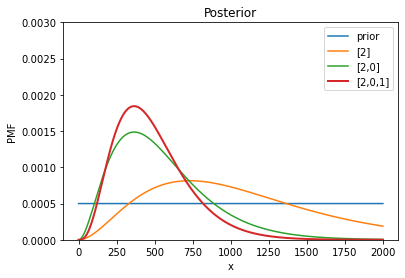

In [210]:
post = prior.copy()
post.plot();
post.update(likelihood, 2)
post.plot();
post.update(likelihood, 0)
post.plot();
post.update(likelihood, 1)
post.plot(lw=2);
decor('Posterior')
plt.ylim([0,0.003])
plt.legend(['prior','[2]','[2,0]','[2,0,1]']);

In [196]:
post.mean()

486.2278641524645

In [197]:
post.max_prob()

365

In [199]:
post.credible_interval(.9)

array([166., 942.])

0.011237085194741203

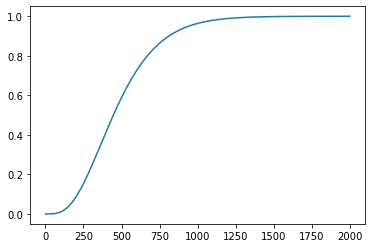

In [200]:
cdf = post.make_cdf()
cdf.plot();
1-cdf.loc[1200]

In [212]:
post.gt_dist(1200)

0.011237085194742358